# CF simulation benchmark

In [51]:
import os
import numpy as np
import pandas as pd
import qiime2 as q2
import re
from biom import Table
from biom import load_table
from gemelli.rpca import rpca, joint_rpca, feature_covariance_table
from tqdm.notebook import tqdm
#from mmvec.q2 import paired_omics #with qiime2-2019.10 version

#import plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [52]:
results_dir = '../../data/simulations/soil_benchmarking/'
microbes = load_table(os.path.join(results_dir, 'data/table.abs.microbes.0.biom'))
metabolites = load_table(os.path.join(results_dir, 'data/table.abs.metabolites.0.biom'))

rel_microbes_dense = pd.read_csv(os.path.join(results_dir, 'data/rel.microbes.0.tsv'), sep='\t', index_col=0)
rel_microbes_dense = Table(rel_microbes_dense.values,
                            rel_microbes_dense.index, rel_microbes_dense.columns)
rel_metabolites_dense = pd.read_csv(os.path.join(results_dir, 'data/rel.metabolites.0.tsv'), sep='\t', index_col=0)
rel_metabolites_dense = Table(rel_metabolites_dense.values,
                               rel_metabolites_dense.index, rel_metabolites_dense.columns)

rel_microbes_sparse = pd.read_csv(os.path.join(results_dir, 'data/rel.microbes.10.tsv'), sep='\t', index_col=0)
rel_microbes_sparse = Table(rel_microbes_sparse.values,
                            rel_microbes_sparse.index, rel_microbes_sparse.columns)
rel_metabolites_sparse = pd.read_csv(os.path.join(results_dir, 'data/rel.metabolites.10.tsv'), sep='\t', index_col=0)
rel_metabolites_sparse = Table(rel_metabolites_sparse.values,
                               rel_metabolites_sparse.index, rel_metabolites_sparse.columns)

mf = pd.read_csv(os.path.join(results_dir, 'data/metadata.tsv'), sep='\t', index_col=0)


In [53]:
tables_subsampled = {}
tables_subsampled['dense'] = [rel_microbes_dense, rel_metabolites_dense]
tables_subsampled['sparse'] = [rel_microbes_sparse, rel_metabolites_sparse]
tables_subsampled

{'dense': [466 x 19 <class 'biom.table.Table'> with 898 nonzero entries (10% dense),
  85 x 19 <class 'biom.table.Table'> with 1480 nonzero entries (91% dense)],
 'sparse': [466 x 19 <class 'biom.table.Table'> with 159 nonzero entries (1% dense),
  85 x 19 <class 'biom.table.Table'> with 1457 nonzero entries (90% dense)]}

# run MMvec and Joint-RPCA here (in python)

## NOTE: R functions are run in a diff. script. 

# joint-RPCA

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/rpca.py:912: RuntimeWarning: Removing 0 features(s) in table(s) but not the ordination.
  warnings.warn('Removing %i features(s) in table(s)'


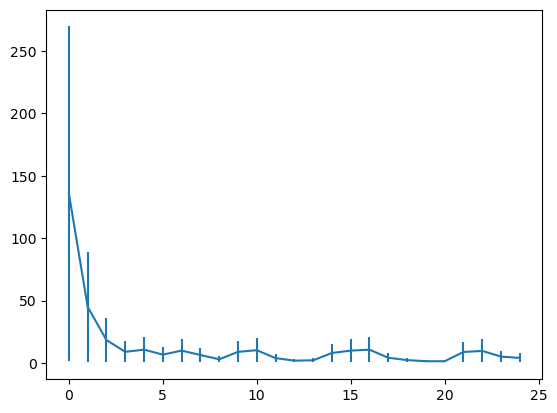

/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/rpca.py:912: RuntimeWarning: Removing 0 features(s) in table(s) but not the ordination.
  warnings.warn('Removing %i features(s) in table(s)'


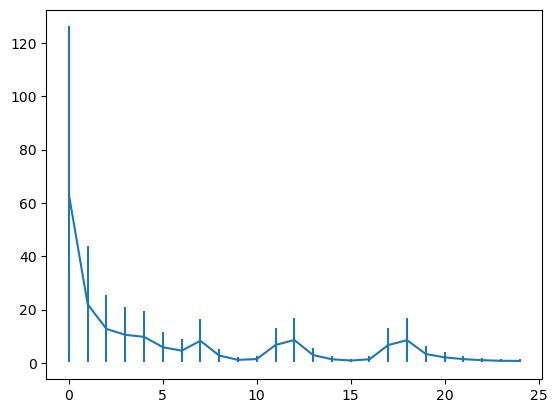

In [66]:
relative_results_joint_rpca = {}
iter_ = {'dense':25, 'sparse':25}
for density_, (microbe_table_tmp, metabolite_table_tmp) in tqdm(tables_subsampled.items()):
    ord_tmp_rel, _, cv_tmp = joint_rpca([metabolite_table_tmp, microbe_table_tmp],
                                       max_iterations=iter_[density_],
                                       min_feature_count=0,
                                       n_components=3,
                                       min_sample_count=0,
                                       min_feature_frequency=0,
                                       sample_metadata=mf,
                                        train_test_column='train_test')
    relative_results_joint_rpca[density_] = ord_tmp_rel
    corr_tmp_rel = feature_covariance_table(ord_tmp_rel)
    #corr_tmp_rel.to_csv(os.path.join(results_dir, 'rel/' + '%s.rpca.csv' % (density_)))
    plt.errorbar(cv_tmp.index, cv_tmp.mean_CV, yerr=cv_tmp.std_CV)
    plt.show()


/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/rpca.py:912: RuntimeWarning: Removing 0 features(s) in table(s) but not the ordination.
  warnings.warn('Removing %i features(s) in table(s)'


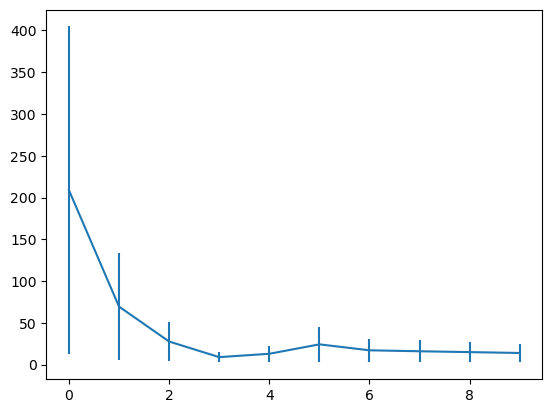

CPU times: user 2.78 s, sys: 111 ms, total: 2.9 s
Wall time: 823 ms


In [68]:
%%time
ord_tmp_abs, dist_tmp_abs, cv_abs = joint_rpca([microbes, metabolites],
                                               n_components=3,
                                               max_iterations=10,
                                               min_feature_count=0,
                                               min_sample_count=0,
                                               min_feature_frequency=0,
                                               sample_metadata=mf,
                                               train_test_column='train_test')
corr_tmp_abs = feature_covariance_table(ord_tmp_abs) 
#corr_tmp_abs.to_csv(os.path.join(results_dir, 'abs/' + 'rpca.csv'))
plt.errorbar(cv_abs.index, cv_abs.mean_CV, yerr=cv_abs.std_CV)
plt.show()

In [ ]:
fig, axn = plt.subplots(1, 3 ,figsize=(15, 4))

for ord_, title_, ax in zip(
    [ord_tmp_abs.samples,
     relative_results_joint_rpca['dense'].samples,
     relative_results_joint_rpca['sparse'].samples], 
    ["Original density\n(microbiome 50% dense)",
     "Medium density\n(microbiome 10% dense)", 
     "Low density\n(microbiome <1% dense)"], axn.flatten()):
    
    ord_plot = pd.concat([ord_, mf], axis=1)
    ord_plot['stage'] = [x.split('_')[-1] for x in ord_plot.index]
    ord_plot['time_int'] = [int(re.findall(r'\d+', t)[0]) for t in ord_plot.time.values]
    print()

    sns.scatterplot(data=ord_plot, x='PC1', y='PC2', hue='time_int', s=60, ax=ax)
    sns.despine()
    ax.set_title(title_, color='black', weight='bold',fontsize=16)
    ax.set_xlabel('PC1 Loadings', color='black', weight='bold',fontsize=16)
    ax.set_ylabel('PC2 Loadings', color='black', weight='bold', fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    if title_ == "Low density\n(microbiome <1% dense)":
        ax.legend(title='Time', loc=2, bbox_to_anchor=(1, 1),
                  fontsize=14, title_fontsize=14)
    else:
        ax.legend_.remove()

plt.tight_layout()
plt.show()

### MMvec

Note: the epochs are scaled to stop at the end of the minimization of the loss/CV

In [454]:
#help(paired_omics)

Help on function paired_omics in module mmvec.q2._method:

paired_omics(microbes:biom.table.Table, metabolites:biom.table.Table, metadata:Metadata=None, training_column:str=None, num_testing_examples:int=5, min_feature_count:int=10, epochs:int=100, batch_size:int=50, latent_dim:int=3, input_prior:float=1, output_prior:float=1, learning_rate:float=0.001, equalize_biplot:float=False, arm_the_gpu:bool=False, summary_interval:int=60) -> (<class 'pandas.core.frame.DataFrame'>, <class 'skbio.stats.ordination._ordination_results.OrdinationResults'>, <class 'qiime2.metadata.metadata.Metadata'>)



/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/biom/table.py:4068: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/pandas/core/generic.py:4583: FutureWarning: SparseSeries is deprecated 

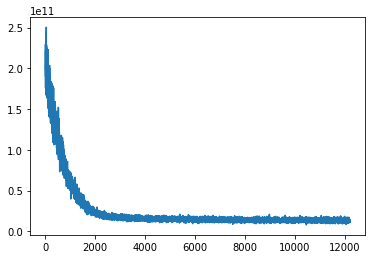

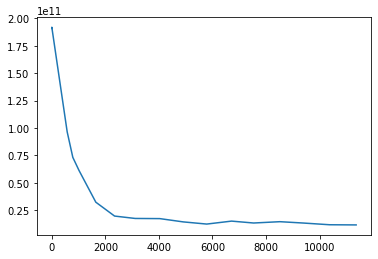

In [455]:
'''
mf['train_test_mmvec'] = [x.capitalize() for x in mf.train_test]
mf.index.name = 'sample_name'
q2mf = q2.Metadata(mf)
mmvec_corr_abs, ord_mmvec_abs, run_stats_abs = paired_omics(microbes, metabolites, epochs=300,
                                                            metadata=q2mf,
                                                            summary_interval=1,
                                                            min_feature_count=0,
                                                            training_column='train_test_mmvec'
                                                           )
#mmvec_corr_abs.T.to_csv(os.path.join(results_dir, 'abs/' + 'mmvec.csv'))
stats_tmp = run_stats_abs.to_dataframe()
plt.plot(stats_tmp['iteration'], stats_tmp['loss'])
plt.show()
stats_tmp = stats_tmp.dropna(subset=['cross-validation'])
plt.plot(stats_tmp['iteration'], stats_tmp['loss'])
plt.show()
'''

/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/biom/table.py:4068: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/pandas/core/generic.py:4583: FutureWarning: SparseSeries is deprecated 

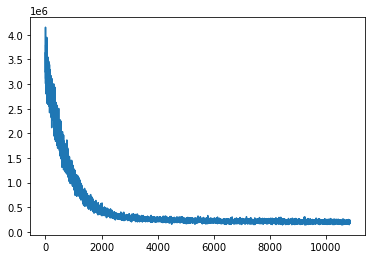

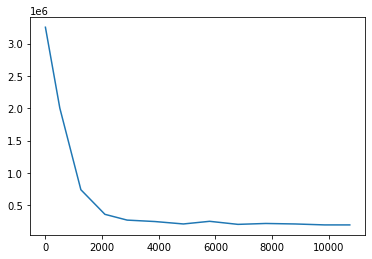

/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/biom/table.py:4068: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/pandas/core/generic.py:4583: FutureWarning: SparseSeries is deprecated 

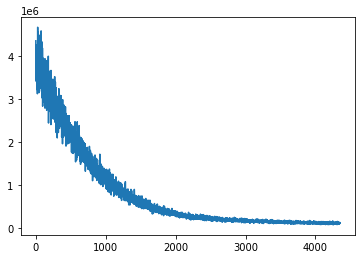

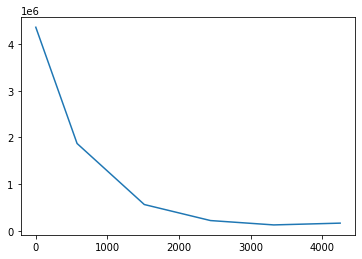

In [456]:
'''
for (density_, (rel_microbes_tmp, rel_metabolites_tmp )), epoch_ in zip(tables_subsampled.items(),
                                                                        [800, 2000]):

    mmvec_corr_rel, ord_mmvec_rel, run_stats_rel = paired_omics(rel_microbes_tmp,
                                                                rel_metabolites_tmp,
                                                                epochs=epoch_,
                                                                metadata=q2mf,
                                                                min_feature_count=0,
                                                                summary_interval=1,
                                                                #training_column='train_test_mmvec'
                                                               )
    #mmvec_corr_rel.T.to_csv(os.path.join(results_dir, 'rel/' + '%s.mmvec.csv' % (density_)))
    stats_tmp = run_stats_rel.to_dataframe()
    plt.plot(stats_tmp['iteration'], stats_tmp['loss'])
    plt.show()
    stats_tmp = stats_tmp.dropna(subset=['cross-validation'])
    plt.plot(stats_tmp['iteration'], stats_tmp['loss'])
    plt.show()
'''


# All other methods are run in *.R (2.2-2.5)